# Consumer Behavior Prediction Service - Data Preprocessing Pipeline

**Project**: Consumer Behavior Prediction Service for UK Retail  
**Phase**: Data Collection and Preprocessing  
**Author**: Data Engineering Team  
**Date**: October 2025

---

## Overview

This notebook implements the complete preprocessing pipeline for forecasting holiday shopping trends 3 months in advance. It includes:

1. **Data Collection**
   - Google Trends data (UK retail keywords)
   - UK Retail Sales Index
   - Simulated Social Media engagement

2. **Data Preprocessing**
   - Alignment to monthly frequency
   - Missing value handling
   - Data merging

3. **Feature Engineering**
   - Lag features (1-6 months)
   - Moving averages (3, 6, 12 months)
   - Volatility indicators
   - Holiday proximity encoding
   - Temporal and cyclical features
   - Trend aggregations

4. **Export**
   - Individual datasets (CSV)
   - Merged processed dataset (CSV)

---

In [1]:
!pip install pytrends

## 1. Setup and Configuration

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.2.3
NumPy version: 1.26.4


In [3]:
# Configuration parameters
START_DATE = '2018-01-01'
END_DATE = '2023-12-31'

# UK retail keywords for Google Trends
RETAIL_KEYWORDS = [
    'christmas gifts',
    'black friday',
    'boxing day sale',
    'summer sale',
    'discount',
    'online shopping',
    'gift ideas',
    'shopping deals',
    'clearance sale',
    'holiday shopping'
]

# Major UK retail holidays (affecting consumer spending)
UK_HOLIDAYS = {
    '2018-12-25': 'Christmas', '2018-12-26': 'Boxing Day', '2018-11-23': 'Black Friday',
    '2019-12-25': 'Christmas', '2019-12-26': 'Boxing Day', '2019-11-29': 'Black Friday',
    '2020-12-25': 'Christmas', '2020-12-26': 'Boxing Day', '2020-11-27': 'Black Friday',
    '2021-12-25': 'Christmas', '2021-12-26': 'Boxing Day', '2021-11-26': 'Black Friday',
    '2022-12-25': 'Christmas', '2022-12-26': 'Boxing Day', '2022-11-25': 'Black Friday',
    '2023-12-25': 'Christmas', '2023-12-26': 'Boxing Day', '2023-11-24': 'Black Friday',
}

print("Configuration loaded:")
print(f"  Date Range: {START_DATE} to {END_DATE}")
print(f"  Keywords: {len(RETAIL_KEYWORDS)} retail terms")
print(f"  Holidays: {len(set(UK_HOLIDAYS.values()))} major retail holidays")

Configuration loaded:
  Date Range: 2018-01-01 to 2023-12-31
  Keywords: 10 retail terms
  Holidays: 3 major retail holidays


## 2. Data Collection

### 2.1 Google Trends Data

In [4]:
# Check if PyTrends is available for live data fetching
try:
    from pytrends.request import TrendReq
    PYTRENDS_AVAILABLE = True
    print(" PyTrends library available - can fetch live Google Trends data")
except ImportError:
    PYTRENDS_AVAILABLE = False
    print(" PyTrends not installed - will generate synthetic trend data")
    print("  To install: !pip install pytrends")

 PyTrends library available - can fetch live Google Trends data


In [5]:
def fetch_google_trends_data():
    """
    Fetch Google Trends data for UK retail keywords.
    Falls back to synthetic data if API is unavailable.
    """
    if PYTRENDS_AVAILABLE:
        print("Fetching live Google Trends data...")
        try:
            pytrends = TrendReq(hl='en-GB', tz=0)
            all_trends = []
            
            for i, keyword in enumerate(RETAIL_KEYWORDS, 1):
                print(f"  [{i}/{len(RETAIL_KEYWORDS)}] Fetching: {keyword}")
                pytrends.build_payload(
                    [keyword], 
                    cat=0, 
                    timeframe=f'{START_DATE} {END_DATE}', 
                    geo='GB'
                )
                trend_data = pytrends.interest_over_time()
                
                if not trend_data.empty:
                    trend_data = trend_data[[keyword]].reset_index()
                    trend_data.columns = ['date', keyword]
                    all_trends.append(trend_data)
            
            # Merge all keyword trends
            trends_df = all_trends[0]
            for df in all_trends[1:]:
                trends_df = pd.merge(trends_df, df, on='date', how='outer')
            
            print(f" Successfully fetched data for {len(RETAIL_KEYWORDS)} keywords")
            return trends_df
            
        except Exception as e:
            print(f" Error fetching from API: {e}")
            print("  Falling back to synthetic data...")
            return generate_synthetic_trends()
    else:
        return generate_synthetic_trends()

def generate_synthetic_trends():
    """
    Generate realistic synthetic Google Trends data.
    Includes seasonal patterns and holiday spikes.
    """
    print("Generating synthetic Google Trends data...")
    
    # Weekly data points
    date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='W')
    trends_data = {'date': date_range}
    
    np.random.seed(42)
    
    for keyword in RETAIL_KEYWORDS:
        # Base trend with random noise
        base_trend = 30 + np.random.randn(len(date_range)) * 5
        
        # Seasonal component (peaks in Q4)
        seasonal_component = 20 * np.sin(2 * np.pi * np.arange(len(date_range)) / 52)
        
        # Holiday spikes
        holiday_spikes = np.zeros(len(date_range))
        for i, date in enumerate(date_range):
            month = date.month
            if month == 11:  # November (Black Friday)
                holiday_spikes[i] = 30
            elif month == 12:  # December (Christmas)
                holiday_spikes[i] = 40
            elif month in [1, 7]:  # January & July sales
                holiday_spikes[i] = 15
        
        # Combine components and clip to 0-100 range
        trends_data[keyword] = np.clip(
            base_trend + seasonal_component + holiday_spikes, 
            0, 100
        )
    
    trends_df = pd.DataFrame(trends_data)
    print(f" Generated synthetic data for {len(RETAIL_KEYWORDS)} keywords")
    print(f"  Date range: {trends_df['date'].min()} to {trends_df['date'].max()}")
    print(f"  Shape: {trends_df.shape}")
    return trends_df

# Fetch or generate Google Trends data
google_trends_df = fetch_google_trends_data()
display(google_trends_df.head())
display(google_trends_df.describe())

Fetching live Google Trends data...
  [1/10] Fetching: christmas gifts
  [2/10] Fetching: black friday
  [3/10] Fetching: boxing day sale
  [4/10] Fetching: summer sale
  [5/10] Fetching: discount
  [6/10] Fetching: online shopping
  [7/10] Fetching: gift ideas
  [8/10] Fetching: shopping deals
  [9/10] Fetching: clearance sale
  [10/10] Fetching: holiday shopping
 Successfully fetched data for 10 keywords


,date,christmas gifts,black friday,boxing day sale,summer sale,discount,online shopping,gift ideas,shopping deals,clearance sale,holiday shopping
0,2018-01-01,2,0,1,21,55,11,29,43,74,34
1,2018-02-01,1,0,0,19,53,11,33,37,60,29
2,2018-03-01,1,0,0,22,53,12,35,31,62,46
3,2018-04-01,1,0,0,32,55,11,24,36,57,61
4,2018-05-01,1,0,0,43,56,11,29,25,54,100


,date,christmas gifts,black friday,boxing day sale,summer sale,discount,online shopping,gift ideas,shopping deals,clearance sale,holiday shopping
count,72,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,2020-12-15 15:20:00,18.069444,7.458333,5.750000,32.958333,67.569444,20.916667,42.902778,31.222222,69.194444,37.902778
min,2018-01-01 00:00:00,1.000000,0.000000,0.000000,10.000000,53.000000,11.000000,24.000000,14.000000,42.000000,13.000000
25%,2019-06-23 12:00:00,1.000000,0.000000,0.000000,16.000000,60.750000,13.750000,31.000000,21.750000,63.000000,26.000000
50%,2020-12-16 12:00:00,2.000000,1.000000,0.000000,26.500000,68.500000,19.000000,34.000000,28.000000,67.000000,32.000000
75%,2022-06-08 12:00:00,16.250000,2.000000,0.250000,38.250000,73.000000,22.000000,40.750000,36.000000,74.250000,40.500000
max,2023-12-01 00:00:00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
std,NaN,30.098115,21.053880,19.125788,23.253918,9.869324,12.715467,21.331165,14.988467,10.849338,18.783541


### 2.2 UK Retail Sales Data

In [6]:
def generate_uk_retail_sales():
    """
    Generate realistic UK retail sales index data.
    Includes growth trend, seasonality, and realistic fluctuations.
    """
    print("Generating UK retail sales index data...")
    
    # Monthly data points
    date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='MS')
    
    np.random.seed(42)
    
    # Starting index value
    base_sales = 100
    growth_rate = 0.002  # ~2.4% annual growth
    sales_values = [base_sales]
    
    # Generate sales with growth trend and seasonality
    for i in range(1, len(date_range)):
        month = date_range[i].month
        
        # Seasonal factors
        seasonal_factor = 1.0
        if month == 12:  # December peak
            seasonal_factor = 1.3
        elif month == 11:  # November (Black Friday)
            seasonal_factor = 1.15
        elif month in [1, 7]:  # January & July sales
            seasonal_factor = 1.08
        elif month in [2, 8]:  # Post-sale slump
            seasonal_factor = 0.95
        
        # Calculate new value with growth, seasonality, and noise
        new_value = sales_values[-1] * (1 + growth_rate) * seasonal_factor
        new_value += np.random.randn() * 2  # Random noise
        sales_values.append(new_value)
    
    retail_df = pd.DataFrame({
        'date': date_range,
        'retail_sales_index': sales_values,
        'retail_sales_value_gbp_millions': np.array(sales_values) * 300  # Convert to GBP millions
    })
    
    print(f" Generated retail sales data: {len(retail_df)} months")
    print(f"  Date range: {retail_df['date'].min()} to {retail_df['date'].max()}")
    print(f"  Shape: {retail_df.shape}")
    return retail_df

# Generate retail sales data
retail_sales_df = generate_uk_retail_sales()
display(retail_sales_df.head())
display(retail_sales_df.describe())

Generating UK retail sales index data...
 Generated retail sales data: 72 months
  Date range: 2018-01-01 00:00:00 to 2023-12-01 00:00:00
  Shape: (72, 3)


,date,retail_sales_index,retail_sales_value_gbp_millions
0,2018-01-01,100.000000,30000.000000
1,2018-02-01,96.183428,28855.028492
2,2018-03-01,96.099267,28829.779968
3,2018-04-01,97.586842,29276.052651
4,2018-05-01,100.828076,30248.422670


,date,retail_sales_index,retail_sales_value_gbp_millions
count,72,72.000000,72.000000
mean,2020-12-15 15:20:00,451.630660,135489.198031
min,2018-01-01 00:00:00,96.099267,28829.779968
25%,2019-06-23 12:00:00,162.307916,48692.374678
50%,2020-12-16 12:00:00,383.356259,115006.877739
75%,2022-06-08 12:00:00,638.987010,191696.102960
max,2023-12-01 00:00:00,1553.775461,466132.638295
std,NaN,346.218423,103865.526853


### 2.3 Simulated Social Media Data

In [7]:
def generate_social_media_data(trends_df):
    """
    Generate simulated social media engagement data.
    Correlated with Google Trends search volumes.
    """
    print("Generating simulated social media engagement data...")
    
    social_df = trends_df[['date']].copy()
    
    np.random.seed(42)
    
    # Calculate average search volume across all keywords
    avg_search_volume = trends_df[RETAIL_KEYWORDS].mean(axis=1)
    
    # Generate correlated social media metrics
    social_df['posts_count'] = (
        avg_search_volume * 1000 + 
        np.random.randn(len(social_df)) * 500
    ).clip(0)
    
    social_df['engagement_score'] = (
        avg_search_volume * 50 + 
        np.random.randn(len(social_df)) * 200
    ).clip(0)
    
    social_df['sentiment_score'] = (
        0.6 + np.random.randn(len(social_df)) * 0.15
    ).clip(0, 1)
    
    social_df['share_count'] = (
        social_df['posts_count'] * 0.3 + 
        np.random.randn(len(social_df)) * 100
    ).clip(0)
    
    social_df['comment_count'] = (
        social_df['posts_count'] * 0.5 + 
        np.random.randn(len(social_df)) * 200
    ).clip(0)
    
    print(f" Generated social media data: {len(social_df)} records")
    print(f"  Features: posts, engagement, sentiment, shares, comments")
    print(f"  Shape: {social_df.shape}")
    return social_df

# Generate social media data
social_media_df = generate_social_media_data(google_trends_df)
display(social_media_df.head())
display(social_media_df.describe())

Generating simulated social media engagement data...
 Generated social media data: 72 records
  Features: posts, engagement, sentiment, shares, comments
  Shape: (72, 6)


,date,posts_count,engagement_score,sentiment_score,share_count,comment_count
0,2018-01-01,27248.357077,1342.834792,0.638982,8097.224601,13680.376912
1,2018-02-01,24230.867849,1527.928731,0.717273,7245.578494,11990.894021
2,2018-03-01,26523.844269,786.050979,0.414457,7908.616926,13220.297684
3,2018-04-01,28461.514928,1549.380501,0.401932,8546.641892,14132.157277
4,2018-05-01,31782.923313,1612.409414,0.678291,9766.342850,15773.588705


,date,posts_count,engagement_score,sentiment_score,share_count,comment_count
count,72,72.000000,72.000000,72.000000,72.000000,72.000000
mean,2020-12-15 15:20:00,33342.149870,1658.272678,0.625314,9995.793075,16681.604730
min,2018-01-01 00:00:00,22943.359878,786.050979,0.372773,6950.967738,11359.643731
25%,2019-06-23 12:00:00,27479.833222,1368.347524,0.496709,8188.662924,13921.634607
50%,2020-12-16 12:00:00,30256.727940,1529.834593,0.644254,9209.234932,15246.559751
75%,2022-06-08 12:00:00,33692.646418,1700.169068,0.700637,10157.794985,16834.355801
max,2023-12-01 00:00:00,56511.272456,3182.237180,1.000000,17031.531106,28463.568324
std,NaN,9089.705868,500.563458,0.136155,2715.374598,4553.170351


## 3. Data Preprocessing

### 3.1 Align Data to Monthly Frequency

In [8]:
print("Aligning all datasets to monthly frequency...\n")

# Convert Google Trends (weekly) to monthly
google_trends_df['date'] = pd.to_datetime(google_trends_df['date'])
google_trends_df['year_month'] = google_trends_df['date'].dt.to_period('M')
google_trends_monthly = google_trends_df.groupby('year_month')[RETAIL_KEYWORDS].mean().reset_index()
google_trends_monthly['date'] = google_trends_monthly['year_month'].dt.to_timestamp()
google_trends_monthly = google_trends_monthly.drop('year_month', axis=1)

print(f"Google Trends: {len(google_trends_df)} weekly → {len(google_trends_monthly)} monthly")

# Convert Social Media (weekly) to monthly
social_media_df['date'] = pd.to_datetime(social_media_df['date'])
social_media_df['year_month'] = social_media_df['date'].dt.to_period('M')
social_media_monthly = social_media_df.groupby('year_month')[
    ['posts_count', 'engagement_score', 'sentiment_score', 'share_count', 'comment_count']
].mean().reset_index()
social_media_monthly['date'] = social_media_monthly['year_month'].dt.to_timestamp()
social_media_monthly = social_media_monthly.drop('year_month', axis=1)

print(f"Social Media: {len(social_media_df)} weekly → {len(social_media_monthly)} monthly")

# Retail Sales already monthly
retail_sales_df['date'] = pd.to_datetime(retail_sales_df['date'])
print(f"Retail Sales: {len(retail_sales_df)} monthly (already aligned)")

print("\n All datasets aligned to monthly frequency")

Aligning all datasets to monthly frequency...

Google Trends: 72 weekly → 72 monthly
Social Media: 72 weekly → 72 monthly
Retail Sales: 72 monthly (already aligned)

 All datasets aligned to monthly frequency


### 3.2 Merge All Datasets

In [9]:
print("Merging all datasets...\n")

# Start with retail sales as base
merged_df = retail_sales_df.copy()
print(f"Base (Retail Sales): {merged_df.shape}")

# Merge Google Trends
merged_df = pd.merge(merged_df, google_trends_monthly, on='date', how='left')
print(f"After Google Trends: {merged_df.shape}")

# Merge Social Media
merged_df = pd.merge(merged_df, social_media_monthly, on='date', how='left')
print(f"After Social Media: {merged_df.shape}")

# Sort by date
merged_df = merged_df.sort_values('date').reset_index(drop=True)

print(f"\n Merged dataset shape: {merged_df.shape}")
print(f"  Date range: {merged_df['date'].min()} to {merged_df['date'].max()}")
print(f"  Missing values: {merged_df.isnull().sum().sum()}")

display(merged_df.head())
display(merged_df.info())

Merging all datasets...

Base (Retail Sales): (72, 3)
After Google Trends: (72, 13)
After Social Media: (72, 18)

 Merged dataset shape: (72, 18)
  Date range: 2018-01-01 00:00:00 to 2023-12-01 00:00:00
  Missing values: 0


,date,retail_sales_index,retail_sales_value_gbp_millions,christmas gifts,black friday,boxing day sale,summer sale,discount,online shopping,gift ideas,shopping deals,clearance sale,holiday shopping,posts_count,engagement_score,sentiment_score,share_count,comment_count
0,2018-01-01,100.000000,30000.000000,2.0,0.0,1.0,21.0,55.0,11.0,29.0,43.0,74.0,34.0,27248.357077,1342.834792,0.638982,8097.224601,13680.376912
1,2018-02-01,96.183428,28855.028492,1.0,0.0,0.0,19.0,53.0,11.0,33.0,37.0,60.0,29.0,24230.867849,1527.928731,0.717273,7245.578494,11990.894021
2,2018-03-01,96.099267,28829.779968,1.0,0.0,0.0,22.0,53.0,12.0,35.0,31.0,62.0,46.0,26523.844269,786.050979,0.414457,7908.616926,13220.297684
3,2018-04-01,97.586842,29276.052651,1.0,0.0,0.0,32.0,55.0,11.0,24.0,36.0,57.0,61.0,28461.514928,1549.380501,0.401932,8546.641892,14132.157277
4,2018-05-01,100.828076,30248.422670,1.0,0.0,0.0,43.0,56.0,11.0,29.0,25.0,54.0,100.0,31782.923313,1612.409414,0.678291,9766.342850,15773.588705


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             72 non-null     datetime64[ns]
 1   retail_sales_index               72 non-null     float64       
 2   retail_sales_value_gbp_millions  72 non-null     float64       
 3   christmas gifts                  72 non-null     float64       
 4   black friday                     72 non-null     float64       
 5   boxing day sale                  72 non-null     float64       
 6   summer sale                      72 non-null     float64       
 7   discount                         72 non-null     float64       
 8   online shopping                  72 non-null     float64       
 9   gift ideas                       72 non-null     float64       
 10  shopping deals                   72 non-null     float64       


None

## 4. Feature Engineering

### 4.1 Temporal Features

In [10]:
print("Creating temporal features...\n")

merged_df['year'] = merged_df['date'].dt.year
merged_df['month'] = merged_df['date'].dt.month
merged_df['quarter'] = merged_df['date'].dt.quarter
merged_df['day_of_year'] = merged_df['date'].dt.dayofyear

print(" Created: year, month, quarter, day_of_year")

# Cyclical encoding for seasonality
merged_df['month_sin'] = np.sin(2 * np.pi * merged_df['month'] / 12)
merged_df['month_cos'] = np.cos(2 * np.pi * merged_df['month'] / 12)

print(" Created: month_sin, month_cos (cyclical encoding)")

display(merged_df[['date', 'year', 'month', 'quarter', 'month_sin', 'month_cos']].head(10))

Creating temporal features...

 Created: year, month, quarter, day_of_year
 Created: month_sin, month_cos (cyclical encoding)


,date,year,month,quarter,month_sin,month_cos
0,2018-01-01,2018,1,1,5.000000e-01,8.660254e-01
1,2018-02-01,2018,2,1,8.660254e-01,5.000000e-01
2,2018-03-01,2018,3,1,1.000000e+00,6.123234e-17
3,2018-04-01,2018,4,2,8.660254e-01,-5.000000e-01
4,2018-05-01,2018,5,2,5.000000e-01,-8.660254e-01
5,2018-06-01,2018,6,2,1.224647e-16,-1.000000e+00
6,2018-07-01,2018,7,3,-5.000000e-01,-8.660254e-01
7,2018-08-01,2018,8,3,-8.660254e-01,-5.000000e-01
8,2018-09-01,2018,9,3,-1.000000e+00,-1.836970e-16
9,2018-10-01,2018,10,4,-8.660254e-01,5.000000e-01


### 4.2 Holiday Features

In [11]:
print("Creating holiday proximity features...\n")

def days_to_nearest_holiday(date, holidays_dict):
    """Calculate days to the nearest holiday"""
    min_distance = float('inf')
    for holiday_date in holidays_dict.keys():
        holiday_dt = pd.to_datetime(holiday_date)
        distance = abs((date - holiday_dt).days)
        if distance < min_distance:
            min_distance = distance
    return min_distance

merged_df['days_to_holiday'] = merged_df['date'].apply(
    lambda x: days_to_nearest_holiday(x, UK_HOLIDAYS)
)

merged_df['is_holiday_month'] = merged_df['date'].apply(
    lambda x: any(
        pd.to_datetime(h).month == x.month and 
        pd.to_datetime(h).year == x.year 
        for h in UK_HOLIDAYS.keys()
    )
).astype(int)

print(" Created: days_to_holiday, is_holiday_month")

display(merged_df[['date', 'days_to_holiday', 'is_holiday_month']].head(10))

Creating holiday proximity features...

 Created: days_to_holiday, is_holiday_month


,date,days_to_holiday,is_holiday_month
0,2018-01-01,326,0
1,2018-02-01,295,0
2,2018-03-01,267,0
3,2018-04-01,236,0
4,2018-05-01,206,0
5,2018-06-01,175,0
6,2018-07-01,145,0
7,2018-08-01,114,0
8,2018-09-01,83,0
9,2018-10-01,53,0


### 4.3 Lag Features

In [12]:
print("Creating lag features (1-6 months)...\n")

for lag in range(1, 7):
    merged_df[f'retail_sales_lag_{lag}'] = merged_df['retail_sales_index'].shift(lag)
    print(f" Created: retail_sales_lag_{lag}")

display(merged_df[['date', 'retail_sales_index'] + 
                   [f'retail_sales_lag_{i}' for i in range(1, 7)]].head(10))

Creating lag features (1-6 months)...

 Created: retail_sales_lag_1
 Created: retail_sales_lag_2
 Created: retail_sales_lag_3
 Created: retail_sales_lag_4
 Created: retail_sales_lag_5
 Created: retail_sales_lag_6


,date,retail_sales_index,retail_sales_lag_1,retail_sales_lag_2,retail_sales_lag_3,retail_sales_lag_4,retail_sales_lag_5,retail_sales_lag_6
0,2018-01-01,100.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-02-01,96.183428,100.000000,NaN,NaN,NaN,NaN,NaN
2,2018-03-01,96.099267,96.183428,100.000000,NaN,NaN,NaN,NaN
3,2018-04-01,97.586842,96.099267,96.183428,100.000000,NaN,NaN,NaN
4,2018-05-01,100.828076,97.586842,96.099267,96.183428,100.000000,NaN,NaN
5,2018-06-01,100.561425,100.828076,97.586842,96.099267,96.183428,100.000000,NaN
6,2018-07-01,108.355278,100.561425,100.828076,97.586842,96.099267,96.183428,100.000000
7,2018-08-01,106.301815,108.355278,100.561425,100.828076,97.586842,96.099267,96.183428
8,2018-09-01,108.049288,106.301815,108.355278,100.561425,100.828076,97.586842,96.099267
9,2018-10-01,107.326437,108.049288,106.301815,108.355278,100.561425,100.828076,97.586842


### 4.4 Moving Averages

In [13]:
print("Creating moving averages (3, 6, 12 months)...\n")

for window in [3, 6, 12]:
    merged_df[f'retail_sales_ma_{window}'] = merged_df['retail_sales_index'].rolling(
        window=window, min_periods=1
    ).mean()
    print(f" Created: retail_sales_ma_{window}")

display(merged_df[['date', 'retail_sales_index', 
                    'retail_sales_ma_3', 'retail_sales_ma_6', 'retail_sales_ma_12']].head(15))

Creating moving averages (3, 6, 12 months)...

 Created: retail_sales_ma_3
 Created: retail_sales_ma_6
 Created: retail_sales_ma_12


,date,retail_sales_index,retail_sales_ma_3,retail_sales_ma_6,retail_sales_ma_12
0,2018-01-01,100.000000,100.000000,100.000000,100.000000
1,2018-02-01,96.183428,98.091714,98.091714,98.091714
2,2018-03-01,96.099267,97.427565,97.427565,97.427565
3,2018-04-01,97.586842,96.623179,97.467384,97.467384
4,2018-05-01,100.828076,98.171395,98.139523,98.139523
5,2018-06-01,100.561425,99.658781,98.543173,98.543173
6,2018-07-01,108.355278,103.248259,99.935719,99.944902
7,2018-08-01,106.301815,105.072839,101.622117,100.739516
8,2018-09-01,108.049288,107.568793,103.613787,101.551713
9,2018-10-01,107.326437,107.225846,105.237053,102.129185


### 4.5 Volatility Indicators

In [14]:
print("Creating volatility indicators...\n")

for window in [3, 6]:
    merged_df[f'retail_sales_volatility_{window}'] = merged_df['retail_sales_index'].rolling(
        window=window, min_periods=1
    ).std()
    print(f" Created: retail_sales_volatility_{window}")

display(merged_df[['date', 'retail_sales_index', 
                    'retail_sales_volatility_3', 'retail_sales_volatility_6']].head(10))

Creating volatility indicators...

 Created: retail_sales_volatility_3
 Created: retail_sales_volatility_6


,date,retail_sales_index,retail_sales_volatility_3,retail_sales_volatility_6
0,2018-01-01,100.000000,NaN,NaN
1,2018-02-01,96.183428,2.698724,2.698724
2,2018-03-01,96.099267,2.228191,2.228191
3,2018-04-01,97.586842,0.835617,1.821053
4,2018-05-01,100.828076,2.417992,2.178537
5,2018-06-01,100.561425,1.799298,2.185045
6,2018-07-01,108.355278,4.424817,4.612853
7,2018-08-01,106.301815,4.039656,4.811983
8,2018-09-01,108.049288,1.107851,4.533918
9,2018-10-01,107.326437,0.878069,3.589758


### 4.6 Aggregate Trend Features

In [15]:
print("Creating aggregate search trend features...\n")

trend_columns = [col for col in merged_df.columns if col in RETAIL_KEYWORDS]

if trend_columns:
    merged_df['avg_search_volume'] = merged_df[trend_columns].mean(axis=1)
    merged_df['max_search_volume'] = merged_df[trend_columns].max(axis=1)
    merged_df['search_volume_std'] = merged_df[trend_columns].std(axis=1)
    
    print(" Created: avg_search_volume, max_search_volume, search_volume_std")

display(merged_df[['date', 'avg_search_volume', 'max_search_volume', 'search_volume_std']].head(10))

Creating aggregate search trend features...

 Created: avg_search_volume, max_search_volume, search_volume_std


,date,avg_search_volume,max_search_volume,search_volume_std
0,2018-01-01,27.0,74.0,24.997778
1,2018-02-01,24.3,60.0,21.822771
2,2018-03-01,26.2,62.0,22.899782
3,2018-04-01,27.7,61.0,24.358663
4,2018-05-01,31.9,100.0,32.167789
5,2018-06-01,32.9,100.0,32.999832
6,2018-07-01,32.9,95.0,31.893747
7,2018-08-01,34.0,80.0,29.318178
8,2018-09-01,29.5,76.0,24.909837
9,2018-10-01,30.1,64.0,21.697158


### 4.7 Growth and Momentum Indicators

In [16]:
print("Creating growth and momentum indicators...\n")

# Year-over-year growth rate
merged_df['yoy_growth_rate'] = merged_df['retail_sales_index'].pct_change(periods=12) * 100
print(" Created: yoy_growth_rate (year-over-year % change)")

# Momentum indicators
merged_df['momentum_3m'] = merged_df['retail_sales_index'] - merged_df['retail_sales_lag_3']
merged_df['momentum_6m'] = merged_df['retail_sales_index'] - merged_df['retail_sales_lag_6']
print(" Created: momentum_3m, momentum_6m")

display(merged_df[['date', 'retail_sales_index', 'yoy_growth_rate', 
                    'momentum_3m', 'momentum_6m']].tail(15))

Creating growth and momentum indicators...

 Created: yoy_growth_rate (year-over-year % change)
 Created: momentum_3m, momentum_6m


,date,retail_sales_index,yoy_growth_rate,momentum_3m,momentum_6m
57,2022-10-01,641.044716,60.703680,-27.343885,24.873741
58,2022-11-01,738.057401,61.073642,99.756293,121.424249
59,2022-12-01,962.056098,61.433820,320.615827,345.543523
60,2023-01-01,1043.049717,61.207859,402.005001,374.661117
61,2023-02-01,991.920677,60.872752,253.863276,353.619569
62,2023-03-01,993.533201,61.735724,31.477103,352.092930
63,2023-04-01,993.307597,61.206489,-49.742120,352.262881
64,2023-05-01,992.901799,61.019854,0.981122,254.844398
65,2023-06-01,996.512654,61.637036,2.979454,34.456556
66,2023-07-01,1081.098614,61.747016,87.791017,38.048897


## 5. Data Validation and Summary

In [17]:
print("="*80)
print("DATASET SUMMARY")
print("="*80)
print()

print(f"Total Records: {len(merged_df)}")
print(f"Total Features: {merged_df.shape[1]}")
print(f"Date Range: {merged_df['date'].min()} to {merged_df['date'].max()}")
print(f"Missing Values: {merged_df.isnull().sum().sum()}")
print()

print("Feature Breakdown:")
print(f"  Temporal: 6 (year, month, quarter, day_of_year, month_sin, month_cos)")
print(f"  Holiday: 2 (days_to_holiday, is_holiday_month)")
print(f"  Lag: 6 (1-6 months)")
print(f"  Moving Averages: 3 (3, 6, 12 months)")
print(f"  Volatility: 2 (3, 6 months)")
print(f"  Search Trends: {len(RETAIL_KEYWORDS)} keywords + 3 aggregates")
print(f"  Social Media: 5 (posts, engagement, sentiment, shares, comments)")
print(f"  Growth/Momentum: 3 (YoY growth, 3m momentum, 6m momentum)")
print(f"  Target: 2 (retail_sales_index, retail_sales_value_gbp_millions)")
print()

print("Missing Values by Column:")
missing_summary = merged_df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    display(missing_summary)
else:
    print("  No missing values!")

DATASET SUMMARY

Total Records: 72
Total Features: 43
Date Range: 2018-01-01 00:00:00 to 2023-12-01 00:00:00
Missing Values: 44

Feature Breakdown:
  Temporal: 6 (year, month, quarter, day_of_year, month_sin, month_cos)
  Holiday: 2 (days_to_holiday, is_holiday_month)
  Lag: 6 (1-6 months)
  Moving Averages: 3 (3, 6, 12 months)
  Volatility: 2 (3, 6 months)
  Search Trends: 10 keywords + 3 aggregates
  Social Media: 5 (posts, engagement, sentiment, shares, comments)
  Growth/Momentum: 3 (YoY growth, 3m momentum, 6m momentum)
  Target: 2 (retail_sales_index, retail_sales_value_gbp_millions)

Missing Values by Column:


yoy_growth_rate              12
retail_sales_lag_6            6
momentum_6m                   6
retail_sales_lag_5            5
retail_sales_lag_4            4
retail_sales_lag_3            3
momentum_3m                   3
retail_sales_lag_2            2
retail_sales_lag_1            1
retail_sales_volatility_3     1
retail_sales_volatility_6     1
dtype: int64

In [18]:
# Display complete dataset info
print("\nDataset Info:")
merged_df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             72 non-null     datetime64[ns]
 1   retail_sales_index               72 non-null     float64       
 2   retail_sales_value_gbp_millions  72 non-null     float64       
 3   christmas gifts                  72 non-null     float64       
 4   black friday                     72 non-null     float64       
 5   boxing day sale                  72 non-null     float64       
 6   summer sale                      72 non-null     float64       
 7   discount                         72 non-null     float64       
 8   online shopping                  72 non-null     float64       
 9   gift ideas                       72 non-null     float64       
 10  shopping deals                   72 non-null     

In [19]:
# Statistical summary
print("\nStatistical Summary:")
display(merged_df.describe())


Statistical Summary:


,date,retail_sales_index,retail_sales_value_gbp_millions,christmas gifts,black friday,boxing day sale,summer sale,discount,online shopping,gift ideas,...,retail_sales_ma_6,retail_sales_ma_12,retail_sales_volatility_3,retail_sales_volatility_6,avg_search_volume,max_search_volume,search_volume_std,yoy_growth_rate,momentum_3m,momentum_6m
count,72,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,...,72.000000,72.000000,71.000000,71.000000,72.000000,72.000000,72.000000,60.000000,69.000000,66.000000
mean,2020-12-15 15:20:00,451.630660,135489.198031,18.069444,7.458333,5.750000,32.958333,67.569444,20.916667,42.902778,...,411.670812,372.149767,25.142344,37.953572,33.394444,78.111111,27.932481,58.305783,50.573510,95.964650
min,2018-01-01 00:00:00,96.099267,28829.779968,1.000000,0.000000,0.000000,10.000000,53.000000,11.000000,24.000000,...,97.427565,97.427565,0.239735,1.821053,23.900000,58.000000,20.909594,46.149689,-49.742120,-5.626849
25%,2019-06-23 12:00:00,162.307916,48692.374678,1.000000,0.000000,0.000000,16.000000,60.750000,13.750000,31.000000,...,161.271489,145.033765,1.888658,7.472245,27.775000,69.750000,24.465771,56.590109,0.139971,12.279629
50%,2020-12-16 12:00:00,383.356259,115006.877739,2.000000,1.000000,0.000000,26.500000,68.500000,19.000000,34.000000,...,294.664063,271.073145,7.608357,20.854577,30.300000,74.500000,27.190754,58.575513,11.006151,49.167822
75%,2022-06-08 12:00:00,638.987010,191696.102960,16.250000,2.000000,0.250000,38.250000,73.000000,22.000000,40.750000,...,622.093570,538.774416,28.351606,43.777332,33.325000,88.500000,31.262161,61.053475,57.357131,135.894931
max,2023-12-01 00:00:00,1553.775461,466132.638295,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,1154.154323,1078.012632,265.661516,205.349439,57.200000,100.000000,38.993447,73.926247,520.756737,557.262807
std,NaN,346.218423,103865.526853,30.098115,21.053880,19.125788,23.253918,9.869324,12.715467,21.331165,...,308.969699,278.590693,44.064783,46.746217,9.007538,12.724110,4.561315,5.115635,101.168052,117.380186


## 6. Data Visualization

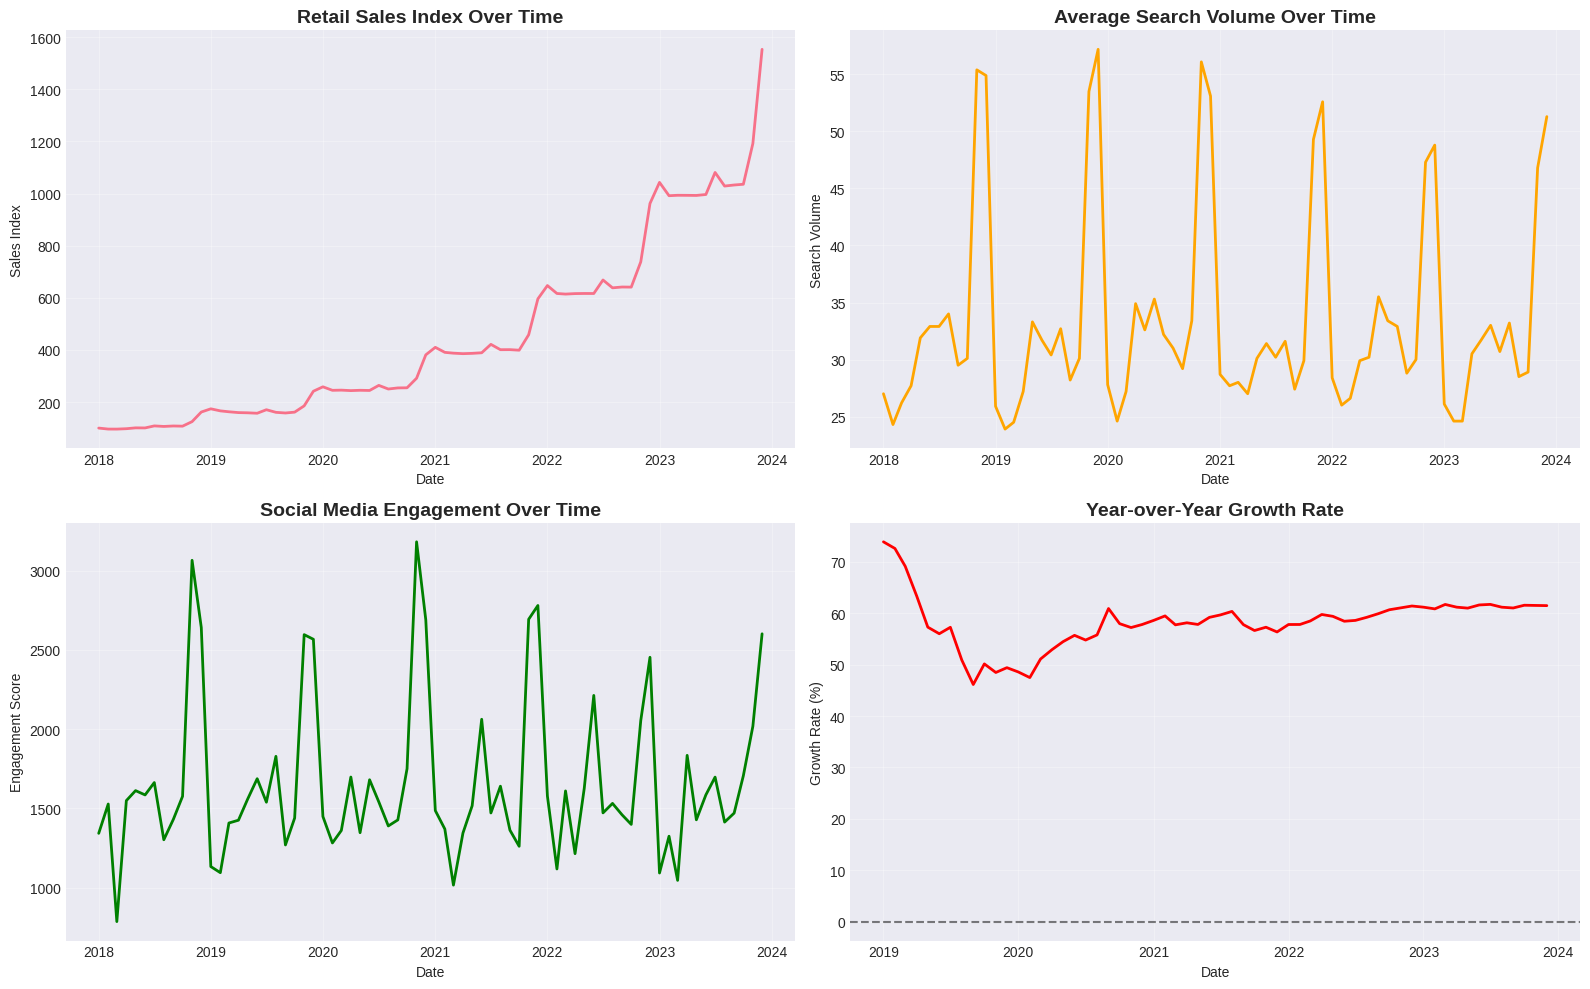

In [20]:
# Plot retail sales trend
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Retail Sales Index
axes[0, 0].plot(merged_df['date'], merged_df['retail_sales_index'], linewidth=2)
axes[0, 0].set_title('Retail Sales Index Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sales Index')
axes[0, 0].grid(True, alpha=0.3)

# Average Search Volume
axes[0, 1].plot(merged_df['date'], merged_df['avg_search_volume'], linewidth=2, color='orange')
axes[0, 1].set_title('Average Search Volume Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Search Volume')
axes[0, 1].grid(True, alpha=0.3)

# Social Media Engagement
axes[1, 0].plot(merged_df['date'], merged_df['engagement_score'], linewidth=2, color='green')
axes[1, 0].set_title('Social Media Engagement Over Time', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Engagement Score')
axes[1, 0].grid(True, alpha=0.3)

# YoY Growth Rate
axes[1, 1].plot(merged_df['date'], merged_df['yoy_growth_rate'], linewidth=2, color='red')
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Year-over-Year Growth Rate', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Growth Rate (%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

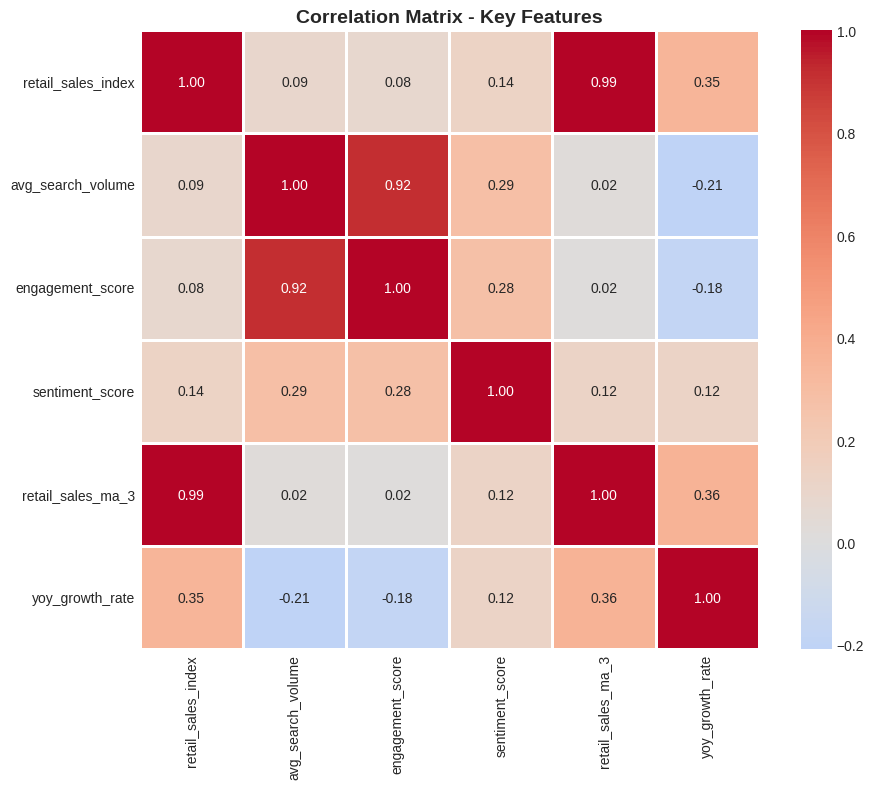

In [21]:
# Correlation heatmap for key features
key_features = [
    'retail_sales_index', 'avg_search_volume', 'engagement_score', 
    'sentiment_score', 'retail_sales_ma_3', 'yoy_growth_rate'
]

plt.figure(figsize=(10, 8))
correlation_matrix = merged_df[key_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Correlation Matrix - Key Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Data Export

In [22]:
print("Exporting processed datasets...\n")

# Export individual datasets
google_trends_monthly.to_csv('google_trends_monthly.csv', index=False)
print(" Saved: google_trends_monthly.csv")

retail_sales_df.to_csv('retail_sales_monthly.csv', index=False)
print(" Saved: retail_sales_monthly.csv")

social_media_monthly.to_csv('social_media_monthly.csv', index=False)
print(" Saved: social_media_monthly.csv")

# Export main processed dataset
merged_df.to_csv('consumer_behavior_dataset_processed.csv', index=False)
print(" Saved: consumer_behavior_dataset_processed.csv")
print("\n" + "="*80)
print("ALL DATASETS EXPORTED SUCCESSFULLY")
print("="*80)

Exporting processed datasets...

 Saved: google_trends_monthly.csv
 Saved: retail_sales_monthly.csv
 Saved: social_media_monthly.csv
 Saved: consumer_behavior_dataset_processed.csv

ALL DATASETS EXPORTED SUCCESSFULLY


## 8. Next Steps

### Ready for Model Development!

The preprocessing pipeline is complete. The dataset is now ready for:

1. **Train/Test Split**
   - Recommended: 80/20 split or time-based split (2018-2022 train, 2023 test)
   - Consider rolling window validation for time series

2. **Baseline Models**
   - Naïve seasonal (last year same month)
   - Moving average
   - Exponential smoothing

3. **Statistical Models**
   - SARIMAX (with holiday effects)
   - Prophet (Facebook's forecasting tool)
   - ARIMA variants

4. **Machine Learning Models**
   - LightGBM / XGBoost
   - Random Forest
   - Neural Networks (LSTM/GRU)

5. **Hybrid Approaches**
   - Prophet + LightGBM residual learning
   - Ensemble methods

6. **Evaluation Metrics**
   - sMAPE ≤ 12%
   - RMSE
   - Direction-of-Change accuracy ≥ 65%
   - MAE

---

### Files Ready for Client:
- `google_trends_monthly.csv` - Search trend data
- `retail_sales_monthly.csv` - Sales index data
- `social_media_monthly.csv` - Engagement data
- **`consumer_behavior_dataset_processed.csv`** - MAIN DATASET (all features)

---

**Preprocessing Complete!**